<a href="https://colab.research.google.com/github/floflokie/SSL/blob/main/TP_Explicabilit%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP : Explicabilité des modèles de deep learning pour les images avec LIME et SHAP**

## **Objectif**
Ce TP vise à explorer comment interpréter les prédictions d’un modèle de deep learning appliqué aux images à l’aide de **LIME** et **SHAP**. Ces outils permettent d’identifier les parties de l’image qui influencent le plus les décisions du modèle, contribuant ainsi à rendre les modèles plus transparents et compréhensibles.

---

## **Contexte**
Les modèles de deep learning, bien qu’efficaces, sont souvent considérés comme des boîtes noires. Comprendre pourquoi un modèle fait une certaine prédiction est essentiel pour :  
1. Identifier les biais potentiels dans le modèle.  
2. Valider la fiabilité des prédictions dans des applications sensibles.  
3. Construire la confiance des utilisateurs finaux.

Dans ce TP, nous allons :  
1. Charger un modèle de classification d’images pré-entraîné avec PyTorch.  
2. Utiliser ce modèle pour prédire les classes d’images fournies.  
3. Appliquer **LIME** et **SHAP** pour expliquer ces prédictions.  
4. Comparer les visualisations générées par ces deux outils et analyser les résultats.

---

## **Plan du TP**

### **Étape 1 : Préparation de l’environnement**
1. Installer les bibliothèques nécessaires pour PyTorch, LIME, et SHAP.  
2. Télécharger ou préparer un ensemble d’images pour les tests (votre dataset préféré, des images issues d’ImageNet, etc.).

---

### **Étape 2 : Charger un modèle pré-entraîné**
1. Nous allons utiliser un modèle pré-entraîné disponible dans PyTorch, comme ResNet18 ou VGG16, avec des poids pré-entraînés sur ImageNet.  
2. Le modèle sera utilisé pour effectuer des prédictions sur les images, après les avoir redimensionnées et normalisées en fonction des besoins du modèle.  
3. Pour chaque image, nous afficherons les classes prédites avec leurs scores de confiance.

---

### **Étape 3 : Explicabilité avec LIME**
1. **Présentation de LIME :**  
   LIME fonctionne en créant des perturbations localisées sur une image (par exemple, en masquant des zones spécifiques) pour mesurer l’impact de chaque zone sur la prédiction.  
2. **Étapes :**  
   - Segmenter l’image en pixels ou en superpixels.  
   - Identifier les zones les plus influentes pour une prédiction donnée.  
   - Générer une heatmap mettant en évidence les zones importantes pour la classe prédite.  
3. Nous analyserons les résultats pour comprendre quelles parties de l’image influencent le plus la prédiction.

---

### **Étape 4 : Explicabilité avec SHAP**
1. **Présentation de SHAP :**  
   SHAP utilise la théorie des jeux pour attribuer une importance à chaque pixel ou groupe de pixels, en mesurant leur contribution à la prédiction.  
2. **Étapes :**  
   - Fournir les images prétraitées au modèle pour calculer les valeurs SHAP.  
   - Générer une visualisation qui montre les contributions positives et négatives des pixels ou des superpixels pour la prédiction.  
3. Nous interpréterons les visualisations en observant les zones qui favorisent ou défavorisent la classe prédite.

---

### **Étape 5 : Comparaison et analyse des résultats**
1. **Comparaison des visualisations :**  
   - Identifier les différences et similitudes entre les résultats de LIME et SHAP.  
   - Analyser les zones mises en évidence par chaque méthode.  
2. **Discussion :**  
   - Quels sont les points forts et limites de chaque méthode ?  
   - Les deux approches donnent-elles des explications cohérentes ?  
   - Quels défis rencontrons-nous en utilisant ces outils avec des modèles de grande taille ou des images complexes ?

---

## **Livrables attendus**
1. Les heatmaps générées par LIME et SHAP pour au moins deux images.  
2. Une analyse comparative des résultats obtenus avec LIME et SHAP.  
---

# TP

### **Étape 1 : Préparation de l'environnement**

1. Installer les bibliothèques nécessaires pour PyTorch, LIME, et SHAP.

In [1]:
%%capture
!pip install lime
!pip install shap
!pip install torch torchvision
!pip install matplotlib

In [2]:
import torch
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import lime
from lime import lime_image
import shap
from torch.utils.data import DataLoader
import torch.nn.functional as F
from skimage import segmentation, color
from skimage.segmentation import mark_boundaries

2. Télécharger ou préparer un ensemble d’images pour les tests (votre dataset préféré, des images issues d’ImageNet, etc.).

In [37]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)), #input size for resnet18
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

classes = dataset.classes

Files already downloaded and verified


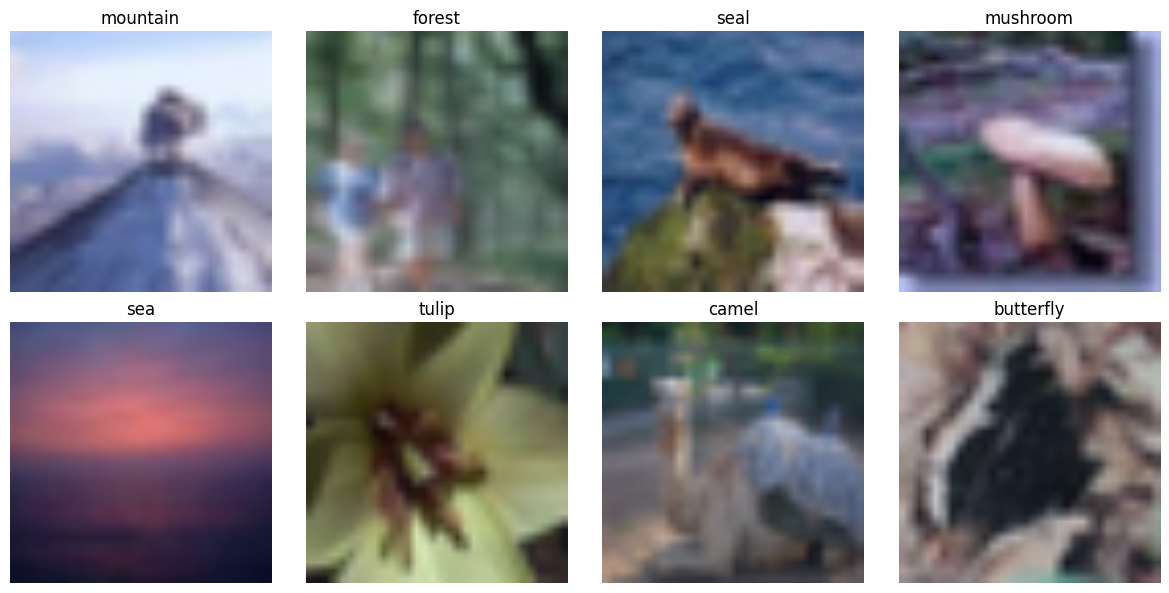

In [38]:
images, labels = next(iter(dataloader))
images_np = np.transpose(images.numpy(), (0, 2, 3, 1))
images_np = (images_np - images_np.min()) / (images_np.max() - images_np.min())

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(images_np[i])
  ax.set_title(classes[labels[i]])
  ax.axis('off')
plt.tight_layout()
plt.show()

### **Étape 2 : Charger un modèle pré-entraîné**


1. Nous allons utiliser un modèle pré-entraîné disponible dans PyTorch, comme ResNet18 ou VGG16, avec des poids pré-entraînés sur ImageNet.  

In [5]:
import torch
import torch.nn.functional as F
import torchvision.models as models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

model.fc = torch.nn.Linear(model.fc.in_features, 100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("model loaded")



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.0MB/s]


model loaded


2. Le modèle sera utilisé pour effectuer des prédictions sur les images, après les avoir redimensionnées et normalisées en fonction des besoins du modèle.  

In [6]:
def predict(images):
      images = images.to(device)
      with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top_probs, top_classes = torch.max(outputs, dim=1)
        return top_probs.cpu().numpy(), top_classes.cpu().numpy()

3. Pour chaque image, nous afficherons les classes prédites avec leurs scores de confiance.

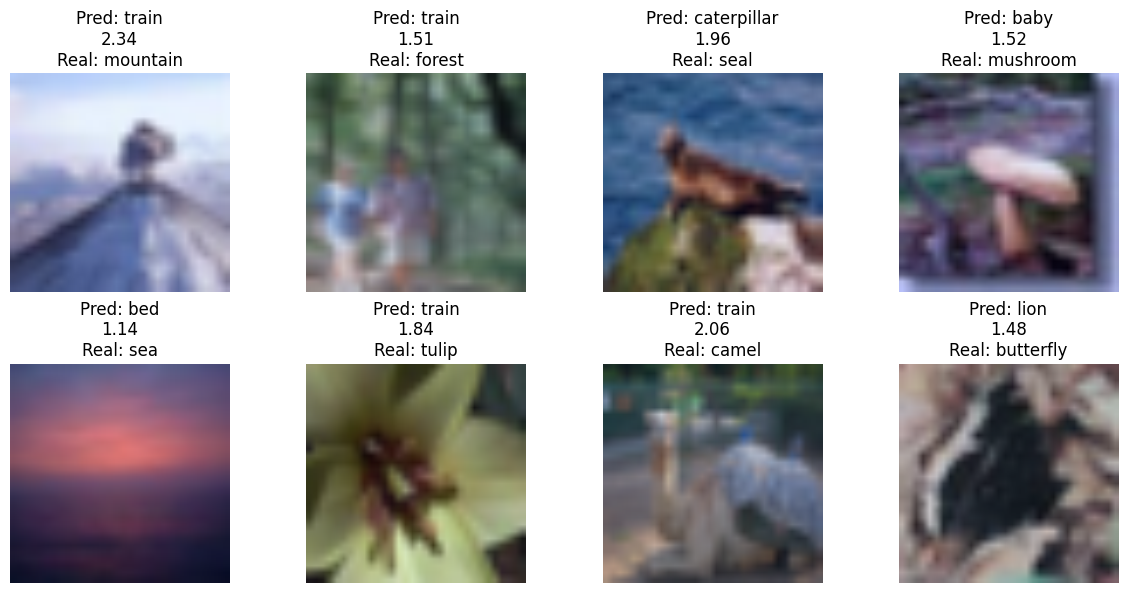

In [7]:
top_probs, top_classes = predict(images)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(images_np[i])
  ax.set_title(f"Pred: {classes[top_classes[i]]}\n{top_probs[i]:.2f}\nReal: {classes[labels[i]]}")
  ax.axis('off')
plt.tight_layout()
plt.show()

### **Étape 3 : Explicabilité avec LIME**

1. **Présentation de LIME :**  
   LIME fonctionne en créant des perturbations localisées sur une image (par exemple, en masquant des zones spécifiques) pour mesurer l’impact de chaque zone sur la prédiction.

In [8]:
explainer = lime_image.LimeImageExplainer()

2. **Étapes :**  
   - Segmenter l’image en pixels ou en superpixels.  
   - Identifier les zones les plus influentes pour une prédiction donnée.  
   - Générer une heatmap mettant en évidence les zones importantes pour la classe prédite.  

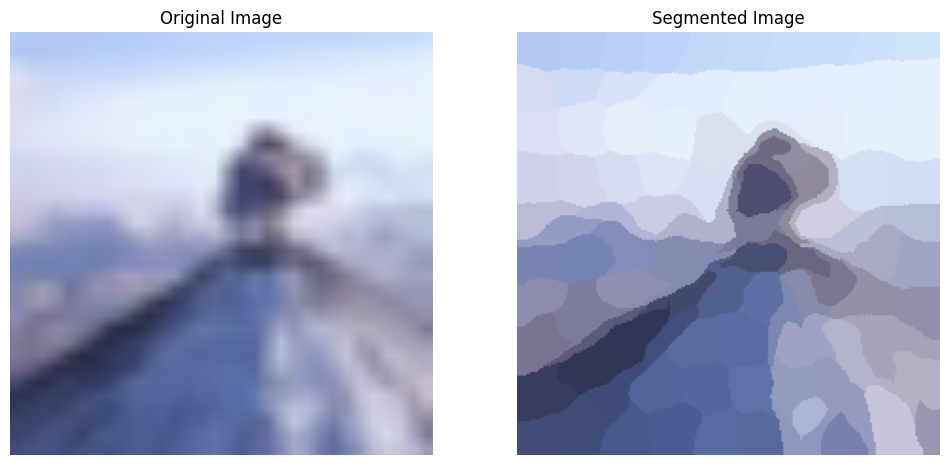

In [9]:
def segment_image(image, num_segments=100):
    segments = segmentation.slic(image, n_segments=num_segments)
    return segments

image_segmented = segment_image(images_np[0])

# show original and segmented
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(images_np[0])
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(color.label2rgb(image_segmented, images_np[0], kind='avg'))
axes[1].set_title("Segmented Image")
axes[1].axis('off')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

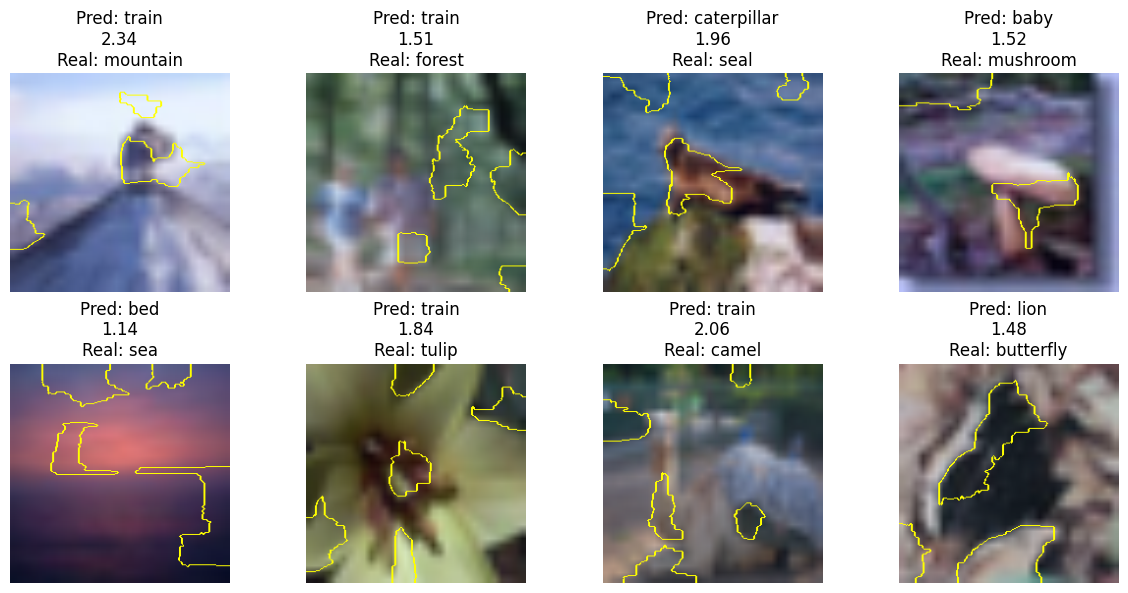

In [10]:
def prediction_lime(images):
  images = torch.tensor(images).permute(0, 3, 1, 2).to(device)
  with torch.no_grad():
    outputs = model(images)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    return probs.cpu().numpy()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
  image = images_np[i]
  image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(device)

  explanation = explainer.explain_instance(
      image,
      lambda x: prediction_lime(x),
      top_labels=1,
      hide_color=0,
      num_samples=1000
  )
  lime_image, mask = explanation.get_image_and_mask(
      explanation.top_labels[0],
      positive_only=True,
      num_features=5,
      hide_rest=False
  )
  axes.flat[i].imshow(mark_boundaries(lime_image, mask))
  axes.flat[i].set_title(f"Pred: {classes[top_classes[i]]}\n{top_probs[i]:.2f}\nReal: {classes[labels[i]]}")
  axes.flat[i].axis('off')

plt.tight_layout()
plt.show()


3. Nous analyserons les résultats pour comprendre quelles parties de l’image influencent le plus la prédiction.


### **Étape 4 : Explicabilité avec SHAP**


1. **Présentation de SHAP :**  
   SHAP utilise la théorie des jeux pour attribuer une importance à chaque pixel ou groupe de pixels, en mesurant leur contribution à la prédiction.  


2. **Étapes :**  
   - Fournir les images prétraitées au modèle pour calculer les valeurs SHAP.  
   - Générer une visualisation qui montre les contributions positives et négatives des pixels ou des superpixels pour la prédiction.  


In [40]:
masker = shap.maskers.Image("inpaint_telea", shape=(224, 224, 3))
def model_predict(x):
    # Assuming the model expects inputs in torch.Tensor format
    with torch.no_grad():  # Disable gradient tracking for inference
        inputs = torch.tensor(x.transpose(0, 3, 1, 2), dtype=torch.float32).to(device)
        return model(inputs).detach().numpy()

e = shap.Explainer(model_predict, masker, output_names=classes)

images_np = images.cpu().numpy()

images_np = (images_np - images_np.min()) / (images_np.max() - images_np.min())
images_np = (images_np * 255).astype(np.uint8)
print(f"Images shape before input to model: {images_np.shape}")  # (N, C, H, W)



Images shape before input to model: (8, 3, 224, 224)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:08, 68.18s/it]               


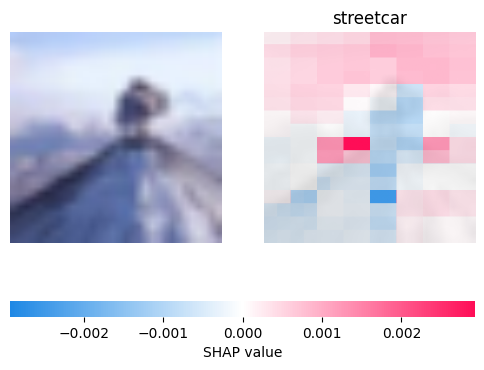

In [41]:

shap_values = e(images_np[:1].transpose(0, 2, 3, 1), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:59, 59.35s/it]               


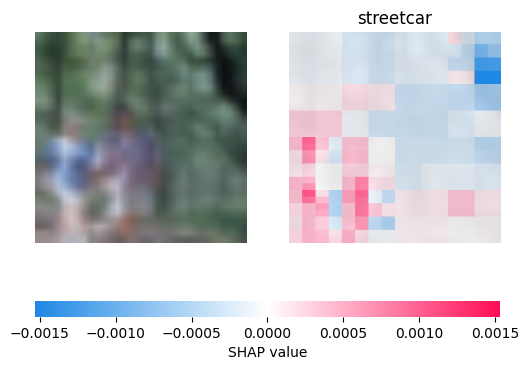

In [42]:
shap_values = e(images_np[1:2].transpose(0, 2, 3, 1), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

3. Nous interpréterons les visualisations en observant les zones qui favorisent ou défavorisent la classe prédite.

### **Étape 5 : Comparaison et analyse des résultats**
1. **Comparaison des visualisations :**  
   - Identifier les différences et similitudes entre les résultats de LIME et SHAP.  
   - Analyser les zones mises en évidence par chaque méthode.  
2. **Discussion :**  
   - Quels sont les points forts et limites de chaque méthode ?  
   - Les deux approches donnent-elles des explications cohérentes ?  
   - Quels défis rencontrons-nous en utilisant ces outils avec des modèles de grande taille ou des images complexes ?

1. Les différences et similitudes entre les résultats de LIME et SHAP sont que Lime montre les zones qui ont influencé la prédiction alors que shap montre le positive et le négative de l'influence de la prédiction.
On peut voir que les prédictions sont à l'oposé quand Lime donne une influence positive, shap dit que c'est une influence négative.

2. LIME :
*   Point fort : se concentre sur une seule prédiction
*   Point faible : les explications sont trop simple

SHAP :

*   Point fort : Donne de explication global du modèle
*   Point faible : plus dur à implémenté, j'ai eu beaucoup de problème et plus long

Les deux approche donne des explication cohérentes car les images sont très flou donc le modèle a beaucoup de mal à classifier.

Le défis que l'on rencontre est le temps de calcul très long. Il y a aussi des explications qui deviennent plus complexe.